Flutungsbeginn war der 12.4.2019. Wir versuchen mit Daten der Sentinel-1- und -2-Satelliten nachzuvollziehen, wie hoch der Wasserstand zum jeweiligen Zeitpunkt war.

In [1]:
! pip install sentinelsat -q

In [2]:
from sentinelsat import SentinelAPI, read_geojson, geojson_to_wkt
from datetime import date
import datetime

In [3]:
# --------------------------------------------------------------------------#
# adjust these lines to search for pictures of the fire you want to look at #
# you should not need to changed anything below this cell                   #
# --------------------------------------------------------------------------#

fire_start_date = date(2020, 5, 28)
fire_end_date = date(2020, 6, 1)
fire_location = 'POINT (13.16832 52.25156)' # note that this is in the order longitude, latitude (or x, y)

In [4]:
# you s
user = 'heyarne'
password='FhnNfPppxNbBm7wCoCGLnfly'
api = SentinelAPI(user, password)

# the "footprint" is what we can use to preselect a certain area;
# the lake is at (51.7874, 14.4226)
# footprint = 'POLYGON((14.359428613281251 51.806620319822734,14.466545312500001 51.806620319822734,14.466545312500001 51.757343872357566,14.359428613281251 51.757343872357566,14.359428613281251 51.806620319822734))'

In [5]:
two_weeks = datetime.timedelta(days=14)
products = api.query(fire_location,
                     platformname='Sentinel-2',
                     processinglevel='Level-2A',
                     date=(fire_start_date - two_weeks, fire_end_date + two_weeks),
                     cloudcoverpercentage=(0,30))

In [6]:
print('Found ' + len(products) + ' results')

TypeError: can only concatenate str (not "int") to str

In [ ]:
products

In [ ]:
from collections import Counter

In [ ]:
# to reduce download size, only download products for one tile
tiles = Counter([p['filename'].split('_')[5] for _, p in products.items()])
most_common_tile, amount = tiles.most_common(1)[0]
most_common_tile, amount

In [ ]:
# we create the directory structure we need for the following notebooks
! mkdir -p input/raster

In [ ]:
api.download_all({k: v for k, v in products.items() if most_common_tile in v['filename']}, 'input/raster')

## Previewing Downloaded Files

In [7]:
from glob import glob
downloaded = glob('input/raster/*.zip')

In [8]:
downloaded

['input/raster/S2A_MSIL2A_20200521T102031_N0214_R065_T32UQC_20200521T115134.zip',
 'input/raster/S2A_MSIL2A_20200528T101031_N0214_R022_T32UQC_20200528T120203.zip',
 'input/raster/S2B_MSIL2A_20200602T100559_N0214_R022_T32UQC_20200602T135324.zip']

In [9]:
from pathlib import Path

import rasterio as r
from rasterio import plot

import matplotlib.pyplot as plt
%matplotlib inline

In [10]:
Path(downloaded[0]).name

'S2A_MSIL2A_20200521T102031_N0214_R065_T32UQC_20200521T115134.zip'

In [43]:
import zipfile

def band_paths(p, bands, resolution=None):
    '''
    Given a zip file at `p`, returns the paths inside p to the raster files containing
    information for the given bands. Because some bands are available in more than one
    resolution, this can be filtered by prodiding a third parameter (e.g. resolution='10m').
    
    The returned paths are formatted in the zip scheme as per Apache Commons VFS and can
    thus be directly opened by rasterio.
    '''
    with zipfile.ZipFile(p) as f:
        files = f.namelist()
        rasters = [f for f in files if f.endswith('.jp2')]
        rasters = ['zip+file://' + p + '!/' + r for r in rasters for b in bands if b in r and (not resolution or resolution in r)]
        return rasters

In [44]:
def rgb_paths(zip_file, resolution='10m'):
    return band_paths(zip_file, ['B02', 'B03', 'B04'], resolution)

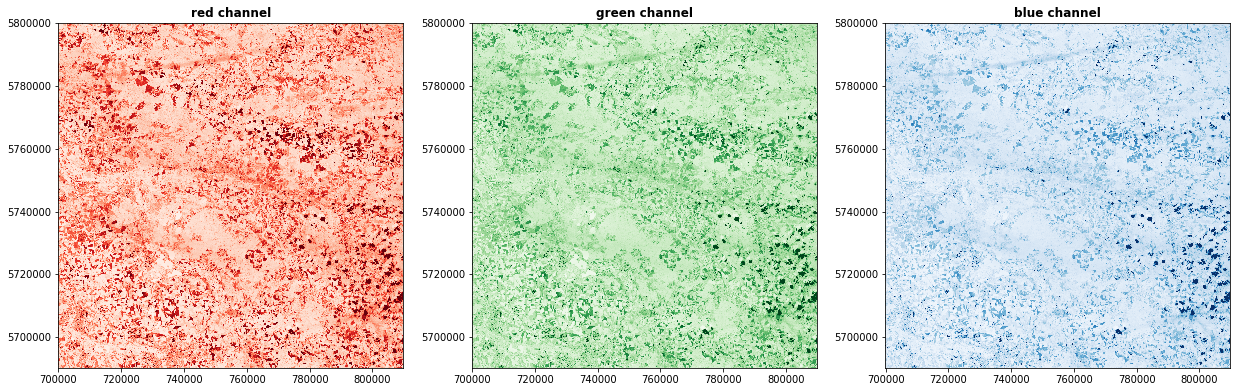

In [98]:
# preview the first downloaded image
with r.open(band_paths(downloaded[0], ['TCI'], '20m')[0]) as true_color:
    fig, (axr, axg, axb) = plt.subplots(1,3, figsize=(21,7))
    plot.show((true_color, 1), ax=axr, cmap='Reds', title='red channel')
    plot.show((true_color, 2), ax=axg, cmap='Greens', title='green channel')
    plot.show((true_color, 3), ax=axb, cmap='Blues', title='blue channel')
    plt.show()